In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
%matplotlib inline

## Time series

We began by reading in the data and performing a little bit of clean up. We also filtered the allegations to years >= 2000 as this is when the data is most complete. This step could have been done in SQL but we weren't sure it was necessary until later in the analysis. The file in question is C4.sql.

In [2]:
df = pd.read_csv(r'../data/findings_beat_month.csv')
df['incident_date'] = pd.to_datetime(df['incident_date'])
df['year'] = df['incident_date'].dt.year

df = df[df['year'] >= 2000]

Time series analysis is hard. We can't just use the number of allegations on a given day because that data is incredibly sparse, most days would have 0 allegations. Instead, we tried to formulate this as a waiting time problem. That is, instead of data points being the day an allegation took place, we looked at the time between allegations. So if there was an allegation on 01/01/2000 and the next one was on 02/01/2000, we say that the data point at 02/01/2000 became 30 days instead of 1 allegation. This translates the problem into a space where sparsity isn't as much of an issue. We did have to account for the first day being NaT because there was no preceeding allegation, but that's a minor fix. 

We decided to focus our primary analysis on individual beats. We decided on this level of aggregation because it matched the rest of the analysis we have previously done. Furthermore, we could have done a citywide analysis, but that losses much of detail that particular beats may have. We say in our visualizations that in many years, the allegations we centered in a few hotspots and the rest of the city was relatively calm. We didn't want to lose out on this key detail. We also could have looked at yearly patterns, or monthly, but stuck with days as our measure of time. On yearly scales we again lose detail. The most important of these is the wait times surrounding the new year. For the early years this isn't a big issue as many beats had in the approaching hundreds of allegations. Lossing on there isn't a major loss. However, toward the later years, the city did better and we were in the tens of allegations. Here the loss of 2 allegations (one from the beginning and one from the end of the year) are more impactful.

Our first pass at analysis was doing linear fits to randomly selected beats. This wasn't the best decision for a few reasons. First, because of the way we created the data (using wait time) it is concentrated in toward the beginning of the time span, when there are a lot of allegations. However, as we progress in time, the wait times become larger and whatever potential predictive power we had is lost. Looking at $R^2$ values, all the models do incredibly bad at predicting the wait time. We should expect a lot of noise, but none of the models manage to do much better than randomly guessing.

In [3]:
beat = 129
sample = df[df['beat_id'] == beat].copy()
# Delta is just the differnce in days between an allegation and the allegation immediately prior
sample['delta'] = sample['incident_date'] - sample['incident_date'].shift(1)
sample['delta'] = sample['delta'].dt.days
temp = sample['incident_date'] - sample['incident_date'].min()

In [4]:
sample

,incident_date,beat_id,final_finding,year,delta
1308,2000-01-27 00:00:00+00:00,129,NS,2000.0,NaN
1491,2000-02-03 00:00:00+00:00,129,NS,2000.0,7.0
1651,2000-02-09 00:00:00+00:00,129,SU,2000.0,6.0
1855,2000-02-18 00:00:00+00:00,129,NS,2000.0,9.0
2683,2000-03-22 00:00:00+00:00,129,NS,2000.0,33.0
...,...,...,...,...,...
112013,2017-07-14 00:00:00+00:00,129,NS,2017.0,25.0
112014,2017-07-14 00:00:00+00:00,129,NS,2017.0,0.0
112015,2017-07-14 00:00:00+00:00,129,NS,2017.0,0.0
112135,2017-08-08 00:00:00+00:00,129,UN,2017.0,25.0


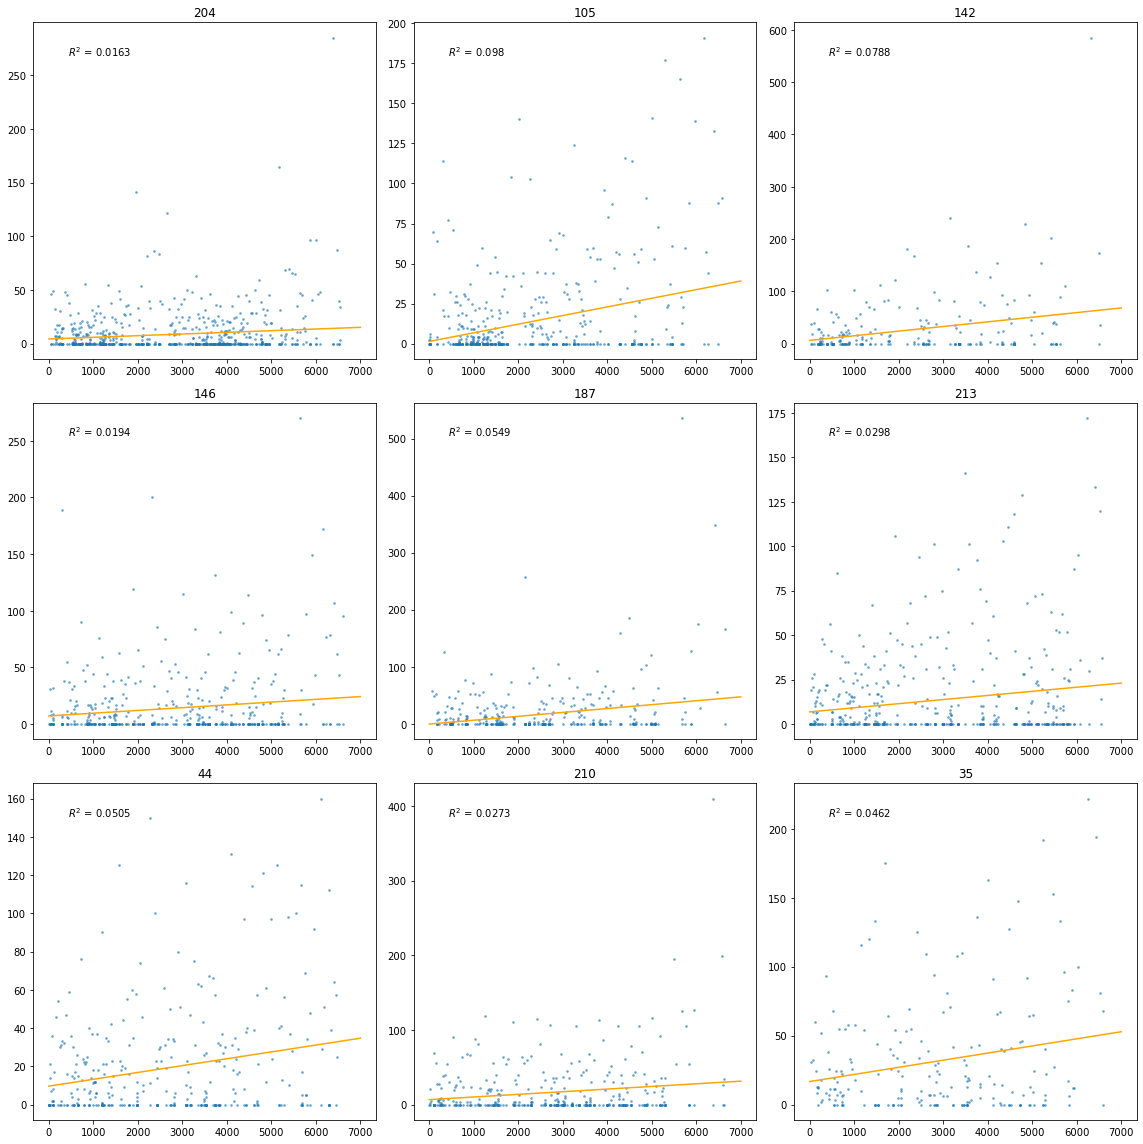

In [5]:
np.random.seed(732)
beats = np.random.choice(df['beat_id'].unique(), 9)
models = []
features = []
zerod = []


for beat in beats:
    sample = df[df['beat_id'] == beat].copy()
    sample['delta'] = sample['incident_date'] - sample['incident_date'].shift(1)
    sample['delta'] = sample['delta'].dt.days
    temp = sample['incident_date'] - sample['incident_date'].min()
    
    lr = LinearRegression()
    data = np.array(temp.dt.days)[1:].reshape(-1, 1)
    lr.fit(data, sample['delta'][1:])
    
    models.append(lr)
    features.append(sample)
    zerod.append(temp)
    
fig, axes = plt.subplots(3, 3, figsize=(16, 16))

xs = np.linspace(0, 7000, 100)
for i, ax in enumerate(axes):
    for j in range(len(ax)):
        ax[j].plot(xs, models[3*i+j].predict(xs.reshape(-1, 1)), c='orange')
        ax[j].scatter(zerod[3*i+j].dt.days, features[3*i+j]['delta'], s=3, alpha=0.5)
        mask = features[3*i+j]['delta'].notnull()
        ax[j].annotate('$R^2$ = {:.3}'.format(r2_score(features[3*i+j]['delta'][mask], models[3*i+j].predict(np.array(zerod[3*i+j].dt.days).reshape(-1, 1))[mask])),
                      (0.1, 0.9), xycoords='axes fraction')
        ax[j].set_title(beats[3*i+j])
        
fig.tight_layout()

Another issue to note, since these are linear models, the wait time will continue to grow forever. We'd like to live in a world where the time between allegations is extremely long, or even nonexistent, but that isn't realistic. Instead, we'd expect our model to show some approach toward an equilibrium. In an attempt to achieve better results, we decided to forgo linearity (which is an admittedly strong assumption we can't make) and try a polynomial fit. We tried tuning the polynomial order as a hyperparameter without huge success. These models did better than their linear counterparts, but still managed meager performance. Neither these models, nor the linear ones manage to have predictive behavior we want. As soon as we exit the data and extrapolate, we get wild results. As seen in 6 of the 9 model visualized turning toward negative wait times. We tried to be clever and avoid issues of sparsity and did. However, instead of eliminating problems, we just traded them out for other ones.

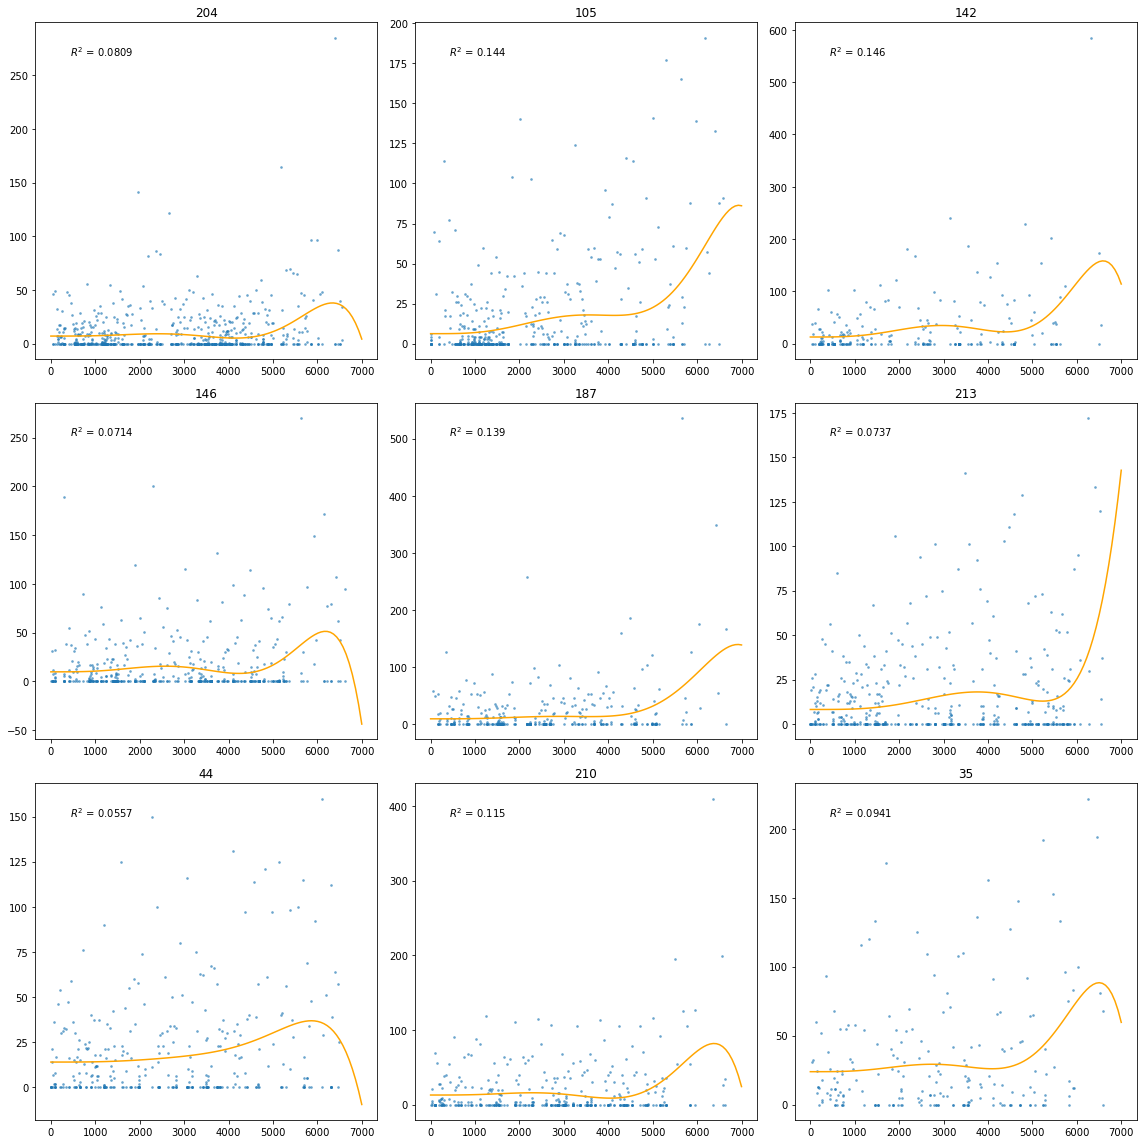

In [6]:
np.random.seed(732)
beats = np.random.choice(df['beat_id'].unique(), 9)
models = []
features = []
polys = []
zerod = []


for beat in beats:
    sample = df[df['beat_id'] == beat].copy()
    sample['delta'] = sample['incident_date'] - sample['incident_date'].shift(1)
    sample['delta'] = sample['delta'].dt.days
    temp = sample['incident_date'] - sample['incident_date'].min()
    
    poly = PolynomialFeatures(7)
    lr = LinearRegression()
    data = np.array(temp.dt.days)[1:].reshape(-1, 1)
    lr.fit(poly.fit_transform(data), sample['delta'][1:])
    
    models.append(lr)
    polys.append(poly)
    features.append(sample)
    zerod.append(temp)
    
fig, axes = plt.subplots(3, 3, figsize=(16, 16))

xs = np.linspace(0, 7000, 100)
for i, ax in enumerate(axes):
    for j in range(len(ax)):
        ax[j].plot(xs, models[3*i+j].predict(polys[3*i+j].transform(xs.reshape(-1, 1))), c='orange')
        ax[j].scatter(zerod[3*i+j].dt.days, features[3*i+j]['delta'], s=3, alpha=0.5)
        mask = features[3*i+j]['delta'].notnull()
        ax[j].annotate('$R^2$ = {:.3}'.format(r2_score(features[3*i+j]['delta'][mask], models[3*i+j].predict(polys[3*i+j].transform(np.array(zerod[3*i+j].dt.days).reshape(-1, 1)))[mask])),
                      (0.1, 0.9), xycoords='axes fraction')
        ax[j].set_title(beats[3*i+j])
        
fig.tight_layout()

# "Moving average"

Our next attempt focused on preventing the issue of extrapolation. Instead of passing a single feature as input, we created a vector of the last 5 wait times and used that as our feature vector. This allowed us to "generate" more data from a single beat. For this analysis, we only did 1 beat, however it is the same as the beat in (1, 1) from the previous analyses. By applying this windowing function to our linear fit, we achieve much better results. It is something like doing a moving average as the prediction. It produces a noiser plot, but the predictions are much better. Furthermore, because we include some history as context for each data point, this model should do better in the long run. It doesn't appear like it has any of the behavior problems exhibited by the previous fits. There, the early days were well fit while later time periods didn't fare as well. In this model, the predictions seem to do equally well across the entire time period.

In [7]:
# Removing duplicated 0 appears to increase performance.
np.random.seed(732)
beat = np.random.choice(df['beat_id'].unique(), 1)[0]
ind = df[df['beat_id'] == beat].drop_duplicates('incident_date').index

temp = df[df['beat_id'] == beat]['incident_date'] - df[df['beat_id'] == beat]['incident_date'].shift(1)
temp = temp[ind]

days = (df[df['beat_id'] == beat]['incident_date'] - df[df['beat_id'] == beat]['incident_date'].min()).dt.days
days = days[ind]

Text(0.1, 0.9, '$R^2$ = 0.498')

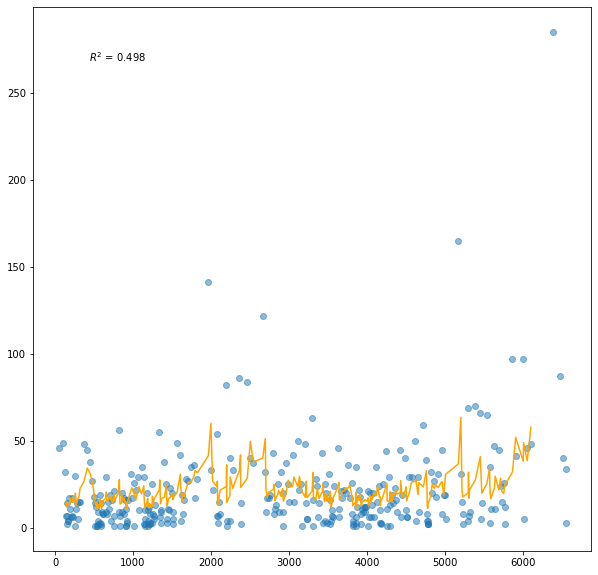

In [8]:
window = 5
features = []
targets = []

for i in range(window-1, len(temp)-window-1):
    features.append(temp[i:i+window].dt.days.to_list())
    targets.append(temp.iloc[i+window+1].days)
    
features = np.array(features)
targets = np.array(targets)

lr = LinearRegression()
lr.fit(features, targets)

fig, axes = plt.subplots(figsize=(10, 10))
axes.plot(days[window:-window], lr.predict(features), c='orange')
axes.scatter(days, temp.dt.days, alpha=0.5)
axes.annotate('$R^2$ = {:.3}'.format(r2_score(temp[4:-6].dt.days ,lr.predict(features))), (0.1, 0.9), xycoords='axes fraction')

### Training with all beats

In [9]:
window = 5
train_features = []
train_targets = []

for beat in df['beat_id'].unique():
    if beat != 6: # used the beat from above as a test set.
        ind = df[df['beat_id'] == beat].drop_duplicates('incident_date').index

        temp = df[df['beat_id'] == beat]['incident_date'] - df[df['beat_id'] == beat]['incident_date'].shift(1)
        temp = temp[ind]

        days = (df[df['beat_id'] == beat]['incident_date'] - df[df['beat_id'] == beat]['incident_date'].min()).dt.days
        days = days[ind]

        for i in range(window-1, len(temp)-window-1):
            train_features.append(temp[i:i+window].dt.days.to_list())
            train_targets.append(temp.iloc[i+window+1].days)

train_features = np.array(train_features)
train_targets = np.array(train_targets)

lr = LinearRegression()
lr.fit(train_features, train_targets)

LinearRegression()

Text(0.1, 0.9, '$R^2$ = 0.23\nTrained on all beats')

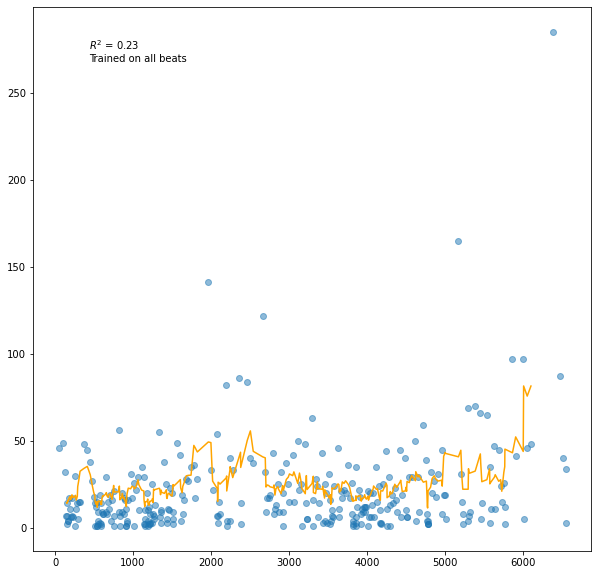

In [10]:
test_features = []
test_targets = []
np.random.seed(732)
beat = np.random.choice(df['beat_id'].unique(), 1)[0]
ind = df[df['beat_id'] == beat].drop_duplicates('incident_date').index

temp = df[df['beat_id'] == beat]['incident_date'] - df[df['beat_id'] == beat]['incident_date'].shift(1)
temp = temp[ind]

days = (df[df['beat_id'] == beat]['incident_date'] - df[df['beat_id'] == beat]['incident_date'].min()).dt.days
days = days[ind]

for i in range(window-1, len(temp)-window-1):
    test_features.append(temp[i:i+window].dt.days.to_list())
    test_targets.append(temp.iloc[i+window+1].days)

test_features = np.array(test_features)
test_targets = np.array(test_targets)

fig, axes = plt.subplots(figsize=(10, 10))
axes.plot(days[window:-window], lr.predict(test_features), c='orange')
axes.scatter(days, temp.dt.days, alpha=0.5)
axes.annotate('$R^2$ = {:.3}\nTrained on all beats'.format(r2_score(temp[4:-6].dt.days ,lr.predict(test_features))), (0.1, 0.9), xycoords='axes fraction')